1. i create a new environment
2. then install all important libreries
3. then download the data of facial features
4. i define the dataset and dataloader class

In [2]:
%pip install matplotlib

  Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.2 MB 3.6 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 3.5 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.1-p

1.loading dataset using path and save there into 7 catagories 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', and 'surprise.'
2.Image Preprocessing: Applies transformations resizing to 48x48, normalization, and tensor conversion.
3.shows count of images 
3.Splits the dataset into 80% training and 20% validation using sklearn.model_selection.train_test_split.
4.Data Processing: Converts images into CNN-ready tensors and stacks them for efficiency. Handles corrupted images by replacing them with placeholder tensors.
5.Data Visualization:
Displays one sample image per emotion category.
Visualizes batches of images using matplotlib for training verification.
6.CNN-Ready Data Saving: Saves processed data as a pickle file for efficient CNN training.
7.DataLoader Creation: Implements batch processing for training using DataLoader.
8.Error Handling: Manages image loading errors and corrupted files.
9.Visualization create png files using matplotlib for visualization 

Loading image paths and labels...
Class Distribution:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
Visualizing sample images...


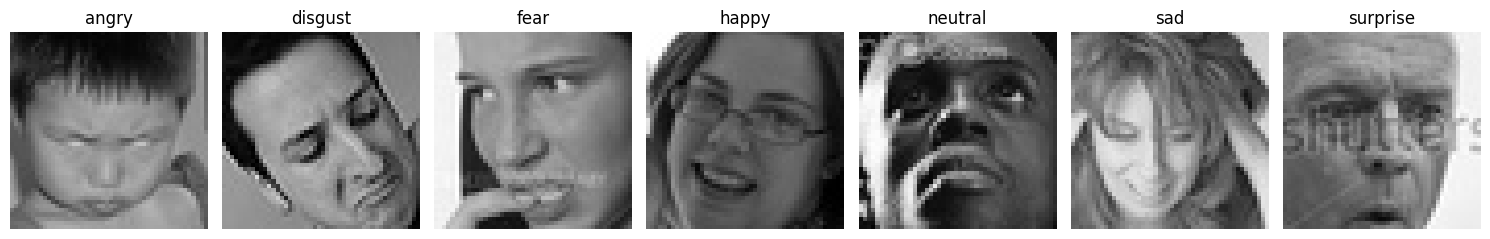

Training samples: 22967, Validation samples: 5742
Ready-for-CNN data saved to D:\bhachu\ready_for_cnn.pkl


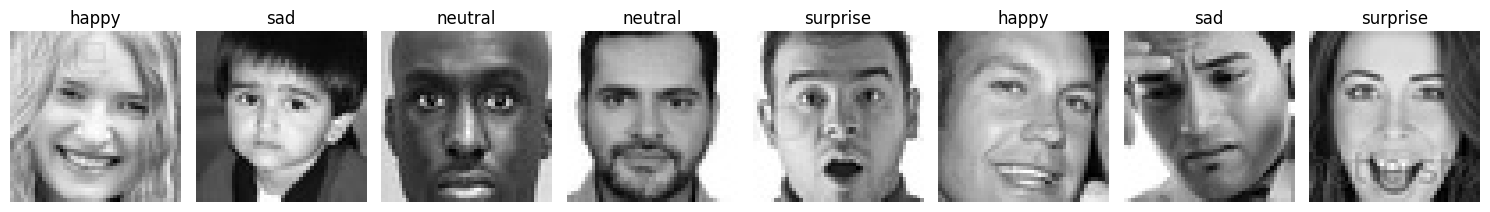

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import sklearn.model_selection
from collections import Counter
import pickle  
class EmotionDatasetPreparation(Dataset):
    def __init__(self, train_path, transform=None):
        self.train_path = train_path
        self.emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.image_paths = []
        self.labels = []
        self.ready_for_cnn = {}
        self._load_image_paths()
    def _load_image_paths(self):
        print("Loading image paths")
        for label, emotion in enumerate(self.emotions):
            emotion_path = os.path.join(self.train_path, emotion)
            if not os.path.exists(emotion_path):
                print(f"Warning: {emotion_path} does not exist!")
                continue
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
        label_counts = Counter(self.labels)
        print("Class Distribution:")
        for emotion, count in label_counts.items():
            print(f"{self.emotions[emotion]}: {count}")
        self._visualize_samples()
        X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
            self.image_paths, self.labels, test_size=0.2, random_state=42
        )

        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
        self.ready_for_cnn['X_train'] = self._process_images(X_train)
        self.ready_for_cnn['y_train'] = y_train
        self.ready_for_cnn['X_val'] = self._process_images(X_val)
        self.ready_for_cnn['y_val'] = y_val
        self.ready_for_cnn['emotions'] = self.emotions
    def _process_images(self, image_paths):
        processed_images = []
        for img_path in image_paths:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                processed_images.append(img)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                processed_images.append(torch.zeros((1, 48, 48))) 
        return torch.stack(processed_images) 
    def _visualize_samples(self):
        print("Visualizing sample images...")
        fig, axes = plt.subplots(1, len(self.emotions), figsize=(15, 5))
        for idx, emotion in enumerate(self.emotions):
            emotion_path = os.path.join(self.train_path, emotion)
            if not os.path.exists(emotion_path):
                continue
            sample_img_name = next(iter(os.listdir(emotion_path)), None)
            if sample_img_name:
                sample_img_path = os.path.join(emotion_path, sample_img_name)
                img = Image.open(sample_img_path).convert('RGB')
                axes[idx].imshow(img)
                axes[idx].set_title(emotion)
                axes[idx].axis('off')
        plt.tight_layout()
        plt.show()
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        return img, label
    def save_ready_for_cnn(self, output_path):
        with open(output_path, 'wb') as f:
            pickle.dump(self.ready_for_cnn, f)
        print(f"Ready-for-CNN data saved to {output_path}")
if __name__ == "__main__":
    train_path = r'D:\bhachu\train'
    test_path = r'D:\bhachu\test'
    train_dataset = EmotionDatasetPreparation(train_path)

    # Save processed data
    train_dataset.save_ready_for_cnn(r'D:\bhachu\ready_for_cnn.pkl')

    # Create DataLoaders for batch processing
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Visualize a batch of data
    def visualize_batch(data_loader, emotions):
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        fig, axes = plt.subplots(1, 8, figsize=(15, 5))
        for idx in range(8):
            img = images[idx].squeeze(0).numpy()  # Convert tensor to numpy array
            axes[idx].imshow(img, cmap="gray")
            axes[idx].set_title(emotions[labels[idx]])
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()

    visualize_batch(train_loader, train_dataset.emotions)


1.Model Architecture: Built a VGG-like CNN with four convolutional blocks using filter sizes of 64, 128, 256, and 512, followed by fully connected layers (1024, 512, output).
2.Activation and Pooling: Used ReLU activations and MaxPooling to improve feature extraction and reduce computational complexity.
3.Regularization: Applied Batch Normalization and Dropout (0.5) to prevent overfitting.
4.Loss Function: Used Cross-Entropy Loss with label smoothing (0.1) for better handling of multi-class classification.
5.Optimizer: Utilized AdamW optimizer with learning rate scheduling (ReduceLROnPlateau) for adaptive learning rates.
6.Data Augmentation: Implemented random horizontal flips, rotations, affine transformations, and Gaussian blur to enhance data diversity.
8.Gradient Clipping: Restricted gradient size to prevent exploding gradients.
9.K-Fold Cross-Validation: Split data into 4 folds to train and evaluate multiple models, selecting the best-performing fold.
9.Best Model Saving: Saved the best model based on validation accuracy for each fold.
10.Tensor Conversion: Loaded and prepared data in PyTorch tensors for efficient model training.
11.Performance Outcome: The fourth fold produced the best-performing model.

In [ ]:
#main 


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import numpy as np
from sklearn.model_selection import KFold

class ImprovedEmotionCNN(nn.Module):
    def __init__(self, input_shape=(1, 48, 48), num_classes=7):
        super(ImprovedEmotionCNN, self).__init__()
        
        # 1st conv block model
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second conv block model
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Third conv block model
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fourth conv block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Calculate the size 
        self.flattened_size = self._calculate_flattened_size(input_shape)
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)

    def _calculate_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        
        identity = x
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

class DataAugmentation:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3)
            ], p=0.2)
        ])
    def __call__(self, img):
        return self.transforms(img)
""" total 20 epochs and 4 splits to create 4 splited models and save it to compare which is good model"""
def train_model_with_kfold(model, X, y, criterion, num_epochs=20, n_splits=4, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    fold_results = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
        print(f'FOLD {fold + 1}')
        X_train, X_val = X[train_ids], X[val_ids]
        y_train, y_val = y[train_ids], y[val_ids]
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        model = ImprovedEmotionCNN().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
        best_val_acc = 0.0
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                
                if np.random.random() > 0.5:
                    lam = np.random.beta(0.4, 0.4)
                    rand_index = torch.randperm(inputs.size()[0]).to(device)
                    targets_a = targets
                    targets_b = targets[rand_index]
                    mixed_x = lam * inputs + (1 - lam) * inputs[rand_index]
                    
                    outputs = model(mixed_x)
                    loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total_train += targets.size(0)
                correct_train += predicted.eq(targets).sum().item()
            
            # Validation
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total_val += targets.size(0)
                    correct_val += predicted.eq(targets).sum().item()
            
            # Calculate accuracy
            train_acc = 100. * correct_train / total_train
            val_acc = 100. * correct_val / total_val
            
            print(f'Epoch: {epoch + 1}/{num_epochs}')
            print(f'Training Loss: {train_loss/len(train_loader):.3f} | Training Acc: {train_acc:.3f}%')
            print(f'Validation Loss: {val_loss/len(val_loader):.3f} | Validation Acc: {val_acc:.3f}%')
            scheduler.step(val_acc)
            
            # Save the  best model..
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
        fold_results.append(best_val_acc)
    return np.mean(fold_results), np.std(fold_results)

def main():
    data_path = r'D:\bhachu\ready_for_cnn.pkl' # dta loader from loading the data path 
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    X_train = torch.tensor(np.array(data['X_train'])).float()  # convert data into tensors and use numpy for best runs not more itme consuming
    X_val = torch.tensor(np.array(data['X_val'])).float()
    y_train = torch.tensor(np.array(data['y_train'])).long()
    y_val = torch.tensor(np.array(data['y_val'])).long()
    if X_train.dim() == 3:
        X_train = X_train.unsqueeze(1)
    if X_val.dim() == 3:
        X_val = X_val.unsqueeze(1)
    
    # Combine train and validation sets for k-fold cross validation
    X = torch.cat([X_train, X_val], dim=0)
    y = torch.cat([y_train, y_val], dim=0)
    print(f"Combined data shapes - X: {X.shape}, y: {y.shape}")

    model = ImprovedEmotionCNN()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # i use it because it is multiclass claasificsation problem
    mean_acc, std_acc = train_model_with_kfold(model, X, y, criterion)
    print(f'Average validation accuracy across folds: {mean_acc:.2f}% ± {std_acc:.2f}%')

if __name__ == '__main__':
    main()


"""
    this model made by bhaskar i was get idea from 
    standard CNN: Sequential layers of convolution, activation, and pooling.
VGG-like Networks: Use small convolution filters (3*3 )stacked deeply, like your model.
ResNet (Residual Networks): Incorporate skip connections to improve gradient flow.
Inception Networks: Use multi-scale convolutions for better feature extraction.
MobileNet/Depthwise Separable CNN

i used 64  / 128 / 256 / 512 image sizes in conv2d format and use relu and maxpool to improve function 
and this model is working best 4th model is working best 

"""

In [7]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# i tried to not break this project points 

Key Components:
	1.	User Interface Development:
	•	Design a Streamlit application that allows users to easily upload images. Do not allow user to upload any other file except image. (Check format, size) 
	•	Focus on creating an intuitive, responsive interface with clear instructions for the user.
	2.	Facial Detection Implementation:
	•	Resize the image: Implement facial detection in the uploaded images using pre trained models and your own model.	
•	Explore options to enhance detection accuracy, precision,recall and F1 score, such as refining detection thresholds or combining methods.
	3.	Facial Feature Extraction:
	•	Use tools like Dlib or Mediapipe to extract key facial landmarks.
	•	Analyze how the accuracy of landmark detection impacts the emotion classification process.
	4.	Emotion Classification:
	•	Train and fine-tune a CNN model using datasets such as FER-2013 available in the Kaggle.
To get the dataset you can use the torchvision library as well. torchvision.datasets.FER2013

	•	Experiment with different CNN architectures and training techniques to maximize the model’s accuracy.
	5.	Performance and Optimization:
	•	Evaluate the model’s performance with metrics like accuracy, precision, and recall.
	•	Implement optimizations to ensure the system runs efficiently and delivers results in real-time.
